# Estimate SEIR parameters from data for different countries

In [1]:
%run ./Load-Data.ipynb

In [2]:
from matplotlib import pyplot
%matplotlib inline

pyplot.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
pyplot.rcParams['figure.figsize'] = 8, 15

In [3]:
%run ./SEIR.ipynb
def predictValues(alpha, beta, gamma, nSteps, N):
    init_vals = N-1, 1, 0, 0
    params = alpha, beta, gamma
   
    t = np.arange(nSteps)
    results = population_seir_model(init_vals, params, t, N)
    return results

In [4]:
def computeGamma(infected, removed, axs):    
    dR_dt= np.diff(removed)
    infected[infected == 0] = 0.0001 # to prevent divide by zero
    gamma = dR_dt / infected[1:]
    axs[4].plot(gamma, label='gamma')
    axs[4].legend(loc="upper right")
    axs[4].set_title('computeGamma')
    axs[4].tick_params(axis='x', rotation=90)
    axs[4].set_xticks(np.arange(0, (len(gamma)+1), 10.0))
    return gamma.mean()

In [5]:
def computeLoss(yhat, infected, removed):
    offsetOfyHat = 0
    offsetOfinfected = 0
    if(len(infected)>len(yhat[2, :])):
        offsetOfinfected = len(infected)-len(yhat[2, :])
    else:
        offsetOfyHat = len(yhat[2, :])-len(infected)
    loss= infected[offsetOfinfected:] - yhat[2,offsetOfyHat:]
    l1 = (loss*loss).sum()
    
    loss= (removed[offsetOfinfected:] - yhat[3,offsetOfyHat:])
    l2 = (loss*loss).sum()
    
    weightForRecovered = 0.1
    return weightForRecovered * l1 + (1 - weightForRecovered) * l2

In [6]:
import numpy as np
def estimateParameters(infected, removed, N, axs):
    minLoss = -1
    minParams=[]
    lossHistory=[]
    alphaHistory=[]
    betaHistory=[]
    gammaHistory=[]
    minYhat = None
   
    alphaSpace = np.arange(0.001,1,0.05)
    betaSpace = np.arange(0.001,1,0.05)
    gammaSpace = np.arange(0,1,0.001)
    for index in range(len(infected)):
        if(infected[index]!=0):
            break
    infected = infected[index : ]
    removed = removed[index : ]
    nSteps = len(infected)
    gamma = computeGamma(infected, removed, axs)
    for alpha in alphaSpace:
        for beta in betaSpace:
#             for gamma in gammaSpace:
            yhat = (predictValues(alpha, beta, gamma, nSteps, N))
            loss = computeLoss(yhat, infected, removed)
            if(loss < minLoss) or (minLoss == -1):
                minLoss = loss
                minParams = [alpha, beta, gamma]
                minYhat = yhat
            lossHistory.append(loss)
            alphaHistory.append(alpha)
            betaHistory.append(beta)
            gammaHistory.append(gamma)
    
    axs[0].plot(alphaHistory, label='alpha')
    axs[0].plot(betaHistory, label='beta')
    axs[0].plot(gammaHistory, label='gamma')
    axs[0].set_title('paramsHistory')  
    axs[0].legend(loc="upper right")
    
    axs[1].plot(lossHistory, label='LossHistory')
    axs[1].set_title('lossHistory')
    axs[1].legend(loc="upper right")
#     axs[1].set_xticks(np.arange(0, (len(lossHistory)+1), 10.0))
    predInfected = minYhat[2,1:]
    #print(predInfected)
    axs[2].plot(predInfected, label = 'Pred-Infected')
    axs[2].set_title('pred-infected & infected')
    axs[2].plot(infected, label = 'Infected')
    axs[2].tick_params(axis='x', rotation=90)
    axs[2].set_xticks(np.arange(0, (len(infected)+1), 10.0))
    axs[2].legend(loc="upper right")
    axs[3].plot(minYhat[3,1:], label='Pred-Removed')
    axs[3].set_title('pred-removed & removed')
    axs[3].tick_params(axis='x', rotation=90)
    axs[3].plot(removed, label = 'Removed')
    axs[3].legend(loc="upper right")
    axs[3].set_xticks(np.arange(0, (len(removed)+1), 10.0))
#     Find index of minimum loss and return params for param history from that index
    return minParams

In [7]:
#params = estimateParameters(total_positive_cases_timeseries, total_removed_cases_timeseries, N)
#print(params)

## Run it for countries

<Figure size 432x288 with 0 Axes>

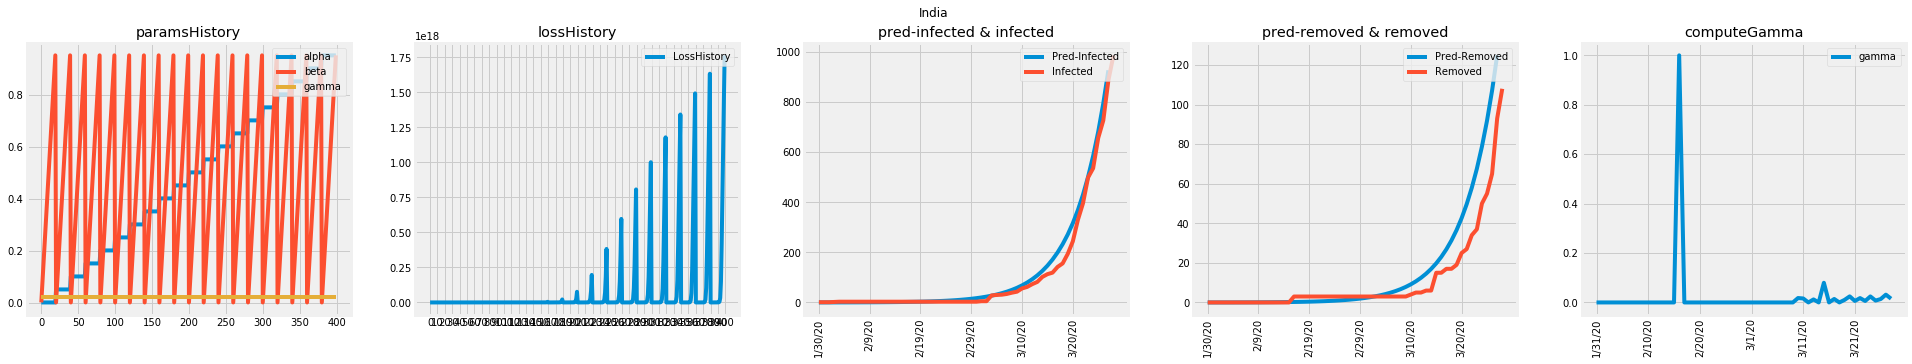

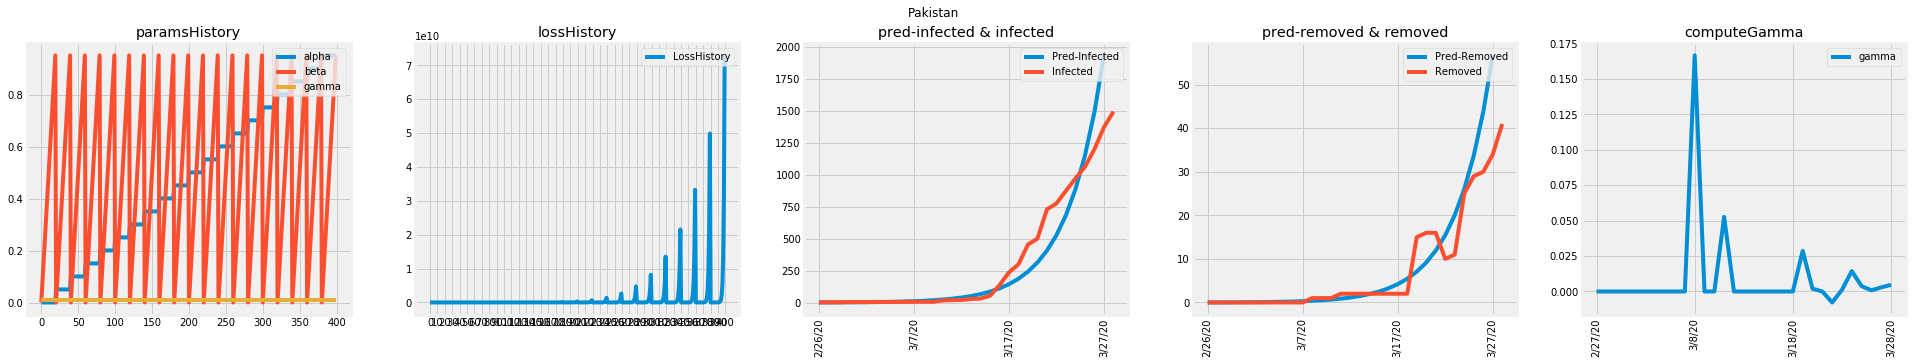

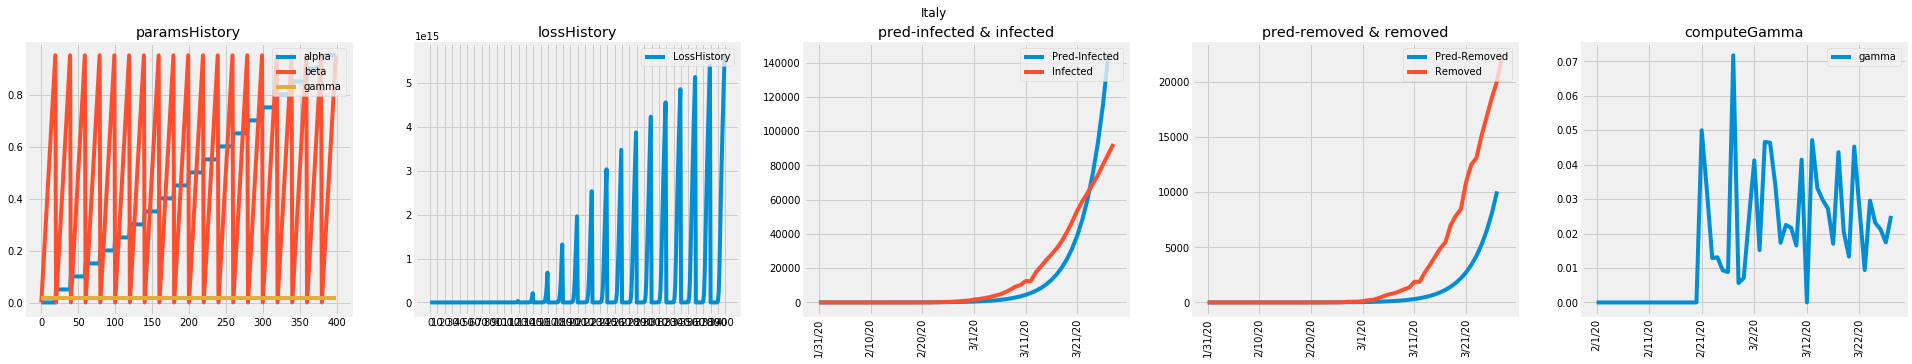

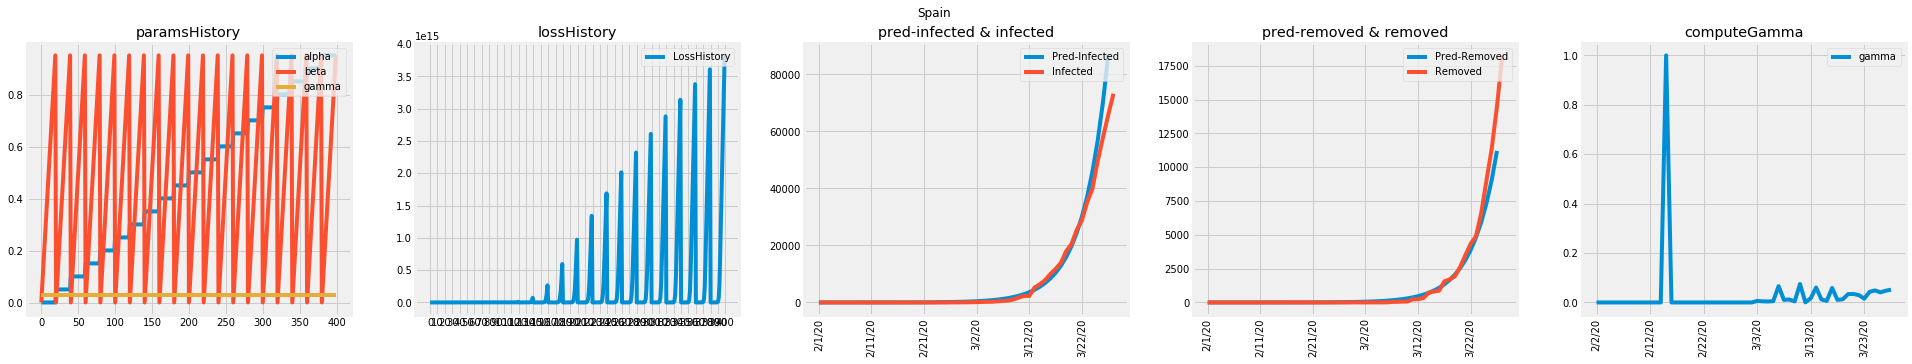

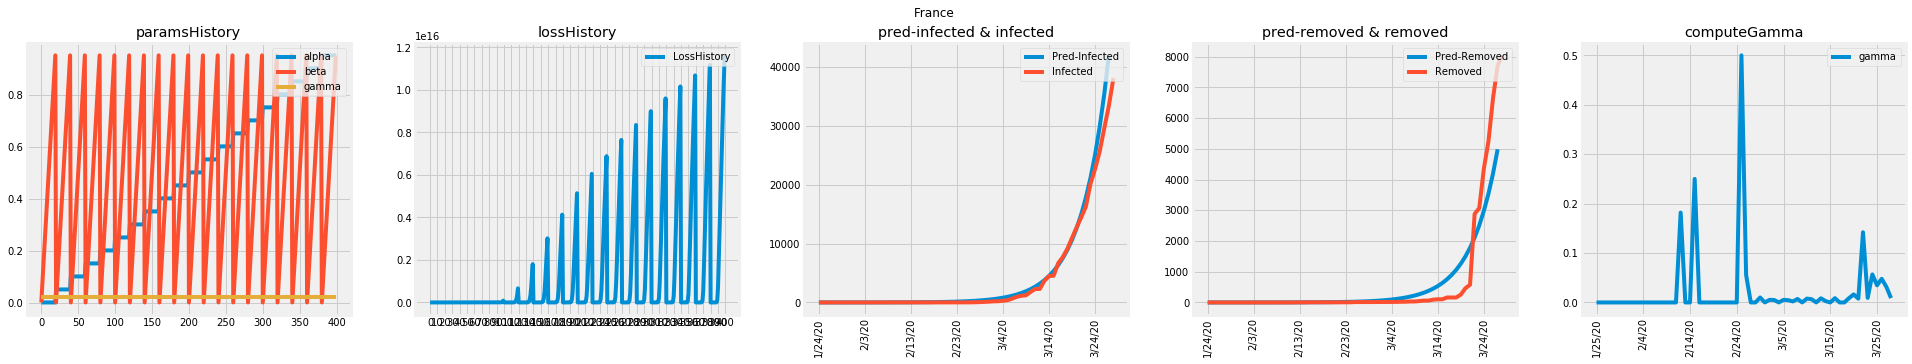

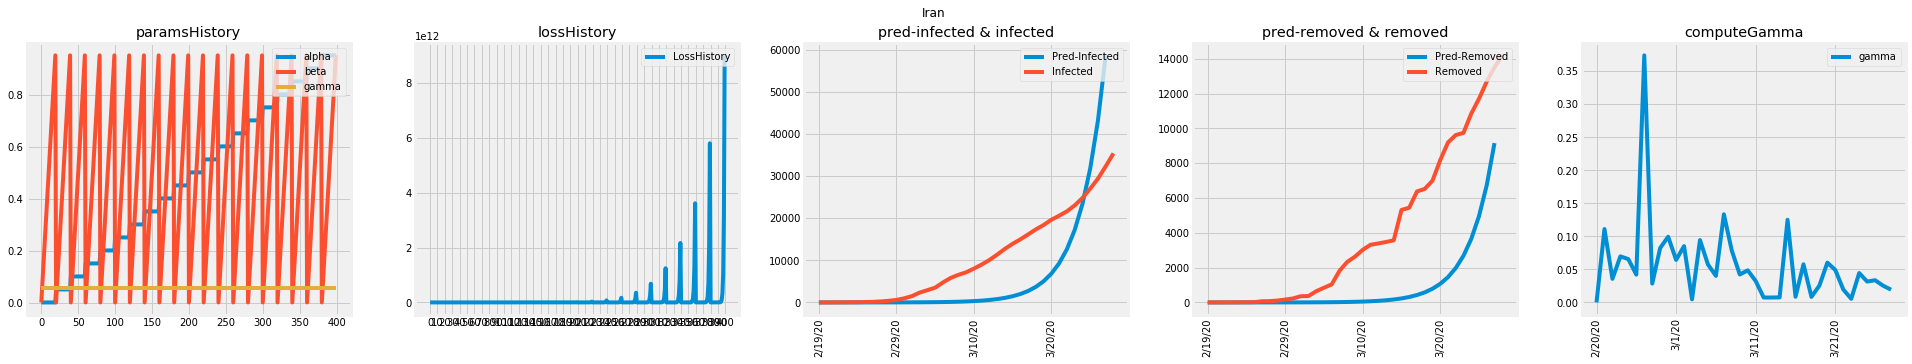

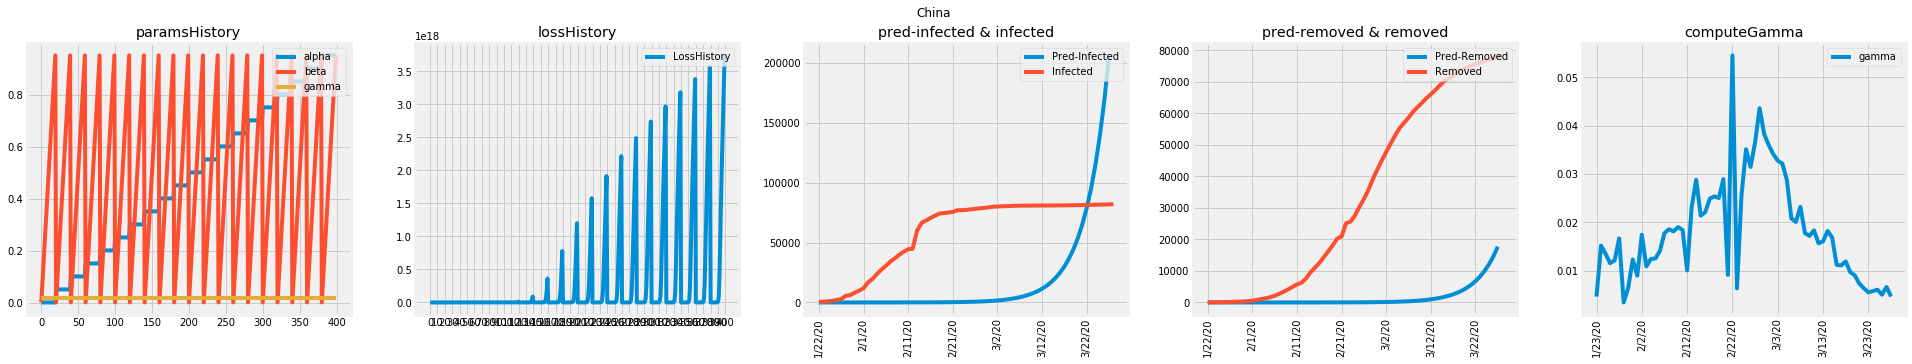

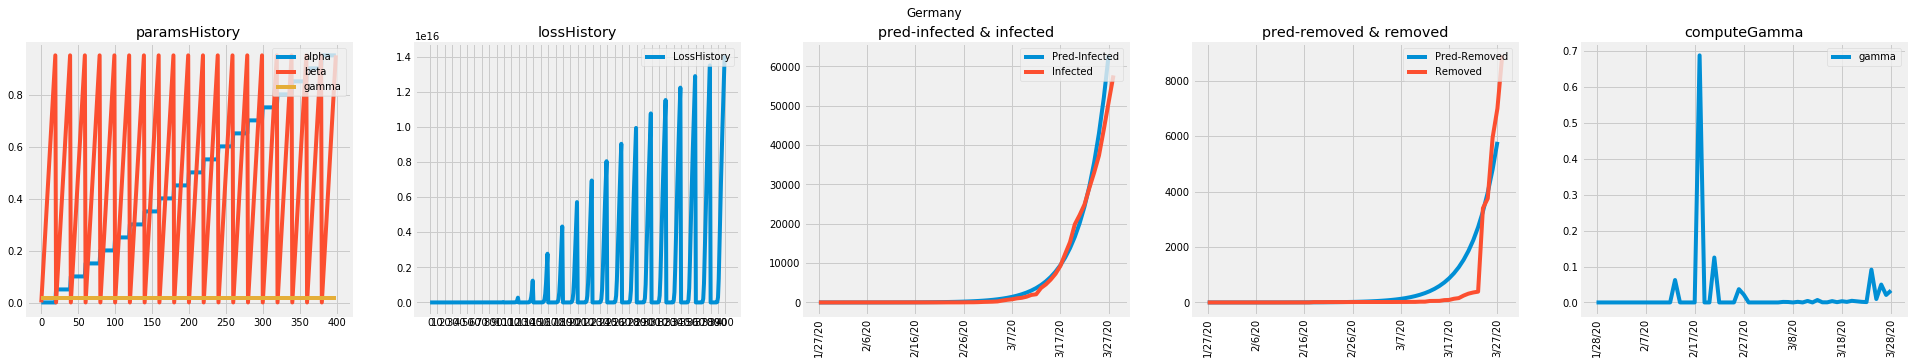

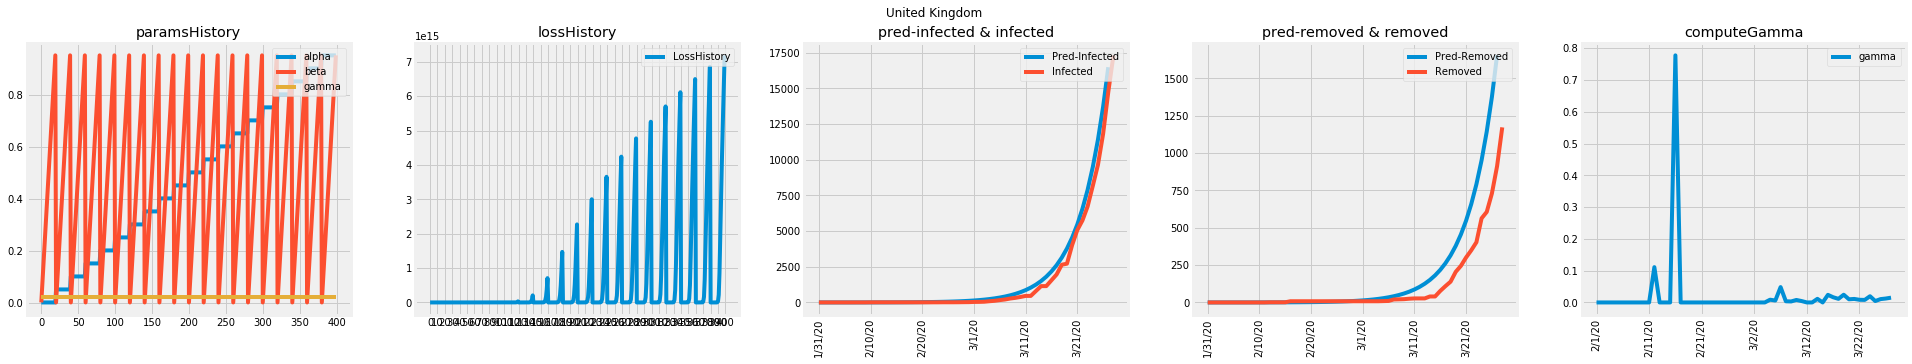

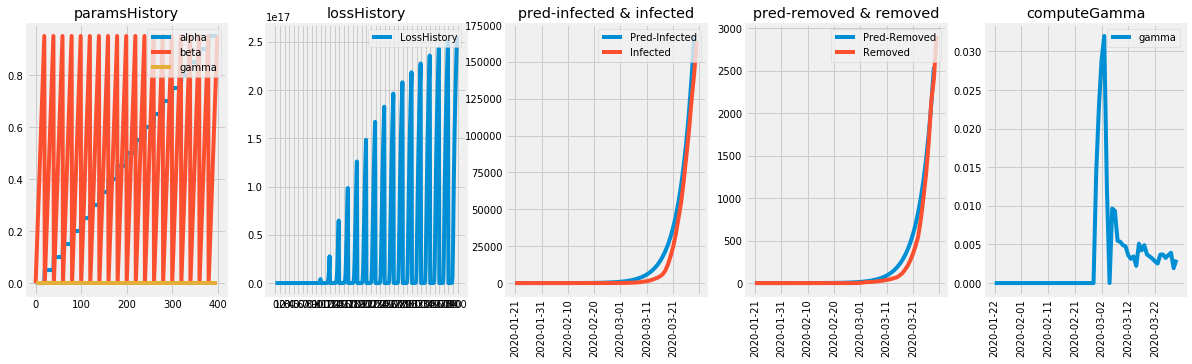

In [8]:
countries = list(["India", "Pakistan", "Italy", "Spain", "France", "Iran", "China", "Germany", "United Kingdom"])

from pandas import *
pyplot.figure(1)
paramsResultDf = DataFrame({'Country': [], 'Params': []})

for country in countries:
    fig, axs = pyplot.subplots(1,5)
    fig.set_size_inches(30, 5)
    fig.suptitle(country)
    N = int(populationDf [populationDf['Country']==country]['Population'])
    confirmedTSDf = confirmedDf.loc[confirmedDf["Country/Region"] == country].sum().T[4:]
    recoveredTSDf = recoveredDf.loc[recoveredDf["Country/Region"] == country].sum().T[4:]
    deathsTSDf = deathsDf.loc[deathsDf["Country/Region"] == country].sum().T[4:]
    params = estimateParameters(confirmedTSDf, (recoveredTSDf+deathsTSDf), N, axs)
    paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params}, ignore_index=True)
    
fig, axs = pyplot.subplots(1,5)
fig.set_size_inches(18.5, 5)    
N = int(populationDf [populationDf['Country']=='United States']['Population'])
params_us = estimateParameters(total_infected_us_timeseries, total_removed_us_timeseries, N, axs)  
paramsResultDf = paramsResultDf.append({'Country': "US" , 'Params': params_us}, ignore_index=True)

In [9]:
display(paramsResultDf)

,Country,Params
0,India,"[0.051000000000000004, 0.801, 0.02236111292958..."
1,Pakistan,"[0.9510000000000001, 0.401, 0.008707547828204699]"
2,Italy,"[0.7010000000000001, 0.35100000000000003, 0.01..."
3,Spain,"[0.751, 0.35100000000000003, 0.03052855571345924]"
4,France,"[0.9510000000000001, 0.251, 0.022251000041520422]"
5,Iran,"[0.801, 0.6010000000000001, 0.0559892369205129]"
6,China,"[0.7010000000000001, 0.30100000000000005, 0.01..."
7,Germany,"[0.651, 0.30100000000000005, 0.01925210763852436]"
8,United Kingdom,"[0.35100000000000003, 0.35100000000000003, 0.0..."
9,US,"[0.30100000000000005, 0.35100000000000003, 0.0..."
